# Optimize SageMaker Endpoint Auto scaling using Inference recommender

## 1. Introduction

Amazon SageMaker real-time endpoints allow you to host ML applications at scale. SageMaker Hosting offers various scaling options for real-time endpoint and they are detailed in this [blog](https://aws.amazon.com/blogs/machine-learning/configuring-autoscaling-inference-endpoints-in-amazon-sagemaker/). In summary, SageMaker endpoint supports three scaling options. The first and the recommended option is TragetTracking, in this option, a target value that represents the average utilization or/and throughput of single host is set as a scaling threshold. Secondly, you can define StepScaling, which is an advanced method for scaling based on the size of alarm breach. The final one is scheduled scaling, which lets you specify an one-time schedule or a recurring schedule. It is always recommended to combine the scaling options to better resilience. 

In this notebook, we provide a design pattern for arriving right deployment configuration for your application. In addition, we provide a list of steps to follow, so even if your application has an unique behavior, such as a different system characteristics or traffic pattern, these systemic approach can be applied to arrive the scaling policies. The procedure is further simplified with the use of Inference recommender, a right sizing and benchmarking tool, built inside SageMaker. 

## 2. Setup 

Note that we are using the `conda_python3` kernel in SageMaker Notebook Instances. This is running Python 3.6. If you'd like to use the same setup, in the AWS Management Console, go to the Amazon SageMaker console. Choose Notebook Instances, and click create a new notebook instance. Upload the current notebook and set the kernel. You can also run this in SageMaker Studio Notebooks with the `Python 3 (Data Science)` kernel.

In the next steps, you'll import standard methods and libraries as well as set variables that will be used in this notebook. The `get_execution_role` function retrieves the AWS Identity and Access Management (IAM) role you created at the time of creating your notebook instance.

In [ ]:
# Install latest botocore
!pip install --upgrade pip awscli botocore boto3 --quiet

In [1]:
from sagemaker import get_execution_role, Session, image_uris
import boto3
import time

region = boto3.Session().region_name
role = get_execution_role()
sm_client = boto3.client("sagemaker", region_name=region)
sagemaker_session = Session()

### Optional: Train an XGBoost model

Let's quickly train an XGBoost model. If you already have a model, you can skip this step and proceed to the next section.

For the purposes of this notebook, we are training an XGBoost model on random data. As a first step install scikit-learn and xgboost

In [2]:
# Install sklearn and XGBoost
!pip3 install -U scikit-learn xgboost==1.5.0 --quiet

### Generate Model and payload

As mentioned, you should skip this step and proceed to the next section if you already have the model. In addition to the model, you should also have a valid payload which can be used for testing your model. 

In this case, we are training the XGBoost model with random data and also generating a sample payload for the exercise. However this procedure is independent of the deployment model or configuration. So you can adopt the same approach for your application and for your deployment choice.

In [3]:
import numpy as np
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Generate dummy data to perform binary classification
seed = 7
features = 50  # number of features
samples = 10000  # number of samples
X = np.random.rand(samples, features).astype("float32")
Y = np.random.randint(2, size=samples)

test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model = XGBClassifier()
# Train the classifier model with random data
model.fit(X_train, y_train)

model_archive_name = "model.tar.gz"
payload_archive_name = "payload.tar.gz"
model_fname = "xgboost.model"
# Save the model
model.save_model(model_fname)

batch_size = 100
# Generate a sample payload which can then be used for benchmarking
np.savetxt("sample.csv", X_test[0:batch_size, :], delimiter=",")

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 3. Create a tarball

To bring your own XGBoost model, SageMaker expects a single archive file in .tar.gz format, containing a model file and optionally inference code. 

Similarly for the payload, SageMaker Inference recommender service expects a single archive file in .tar.gz format, which list of valid samples. 

In [4]:
!tar -cvpzf {model_archive_name} 'xgboost.model'
!tar -cvzf {payload_archive_name} sample.csv

xgboost.model
sample.csv


## 4. Upload to S3

We now have a model and the payload archive ready. We need to upload it to S3 before we can use with Inference Recommender. Furthermore, we will use the SageMaker Python SDK to handle the upload.

In [5]:
# model package tarball (model artifact + inference code)
model_url = sagemaker_session.upload_data(path=model_archive_name, key_prefix="model")
sample_payload_url = sagemaker_session.upload_data(path=payload_archive_name, key_prefix="payload")
print("model uploaded to: {} and the sample payload to {}".format(model_url, sample_payload_url))

model uploaded to: s3://sagemaker-us-west-2-027412998179/model/model.tar.gz and the sample payload to s3://sagemaker-us-west-2-027412998179/payload/payload.tar.gz


## 5. Container image URL

If you don’t have an inference container image, you can use one of the open source AWS [Deep Learning Containers (DLCs)](https://github.com/aws/deep-learning-containers) provided by AWS to serve your ML model. The code below retrieves a SageMaker managed container for XGBoost.

In [6]:
framework_version = "1.5-1"
framework = "xgboost"
container_url = image_uris.retrieve(framework, region, framework_version)
container_url

'246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.5-1'

## 6a. Identify Application characteristics

To arrive to the correct scaling property, the first step in the plan is to find application behavior on the chosen hardware. This can be achieved by running the application on a single host and increasing the request load to the endpoint gradually until it saturates.

For benchmarking, we use the Inference recommender `Default` job. The Default job, is a recommendation job, however we can limit the search to a single instance by passing the instance type in the supported instances. The service then provisioning the endpoint, gradually increases the request and stops when the benchmark reaches saturation or if the endpoint invoke API call fails for 1% of the results. 

In [7]:
from inference_recommender import trigger_inference_recommender_job

# For this usecase we have using ml.c5.large instance type
instance_type = "ml.c5.large"

# We are starting an inference recommender job. The job uses model_url, container_url and instance type
# for provisioning SageMaker endpoint and then uses sample_payload for benchmarking the endpoint.
# As part of the benchmarking, the service increasing the request load to the endpoint gradually
# until it saturates. In many cases, the endpoint can no longer handle any more requests and performance
# begins to deteriorate after saturation. Inference recommender will then stop the benchmark and return results.
job_name, model_package_arn = trigger_inference_recommender_job(
    model_url=model_url,
    payload_url=sample_payload_url,
    container_url=container_url,
    instance_type=instance_type,
    execution_role=role,
    framework=framework,
    framework_version=framework_version,
)
print("Inference recommender job_name={} model_package_arn={}".format(job_name, model_package_arn))

Inference Recommender Job recommender-instance-1670628375 is in progress
Inference Recommender Job recommender-instance-1670628375 is in progress
Inference Recommender Job recommender-instance-1670628375 is in progress
Inference Recommender Job recommender-instance-1670628375 is in progress
Inference Recommender Job recommender-instance-1670628375 is in progress
Inference Recommender Job recommender-instance-1670628375 is in progress
Inference recommender job completed
Inference recommender job_name=recommender-instance-1670628375 model_package_arn=arn:aws:sagemaker:us-west-2:027412998179:model-package/xgboost-model-1670628374/1


## 6b. Analyzing the result:

We then analyze the results using hosting endpoint metrics. Below is a visualization of the invocation metrics, and from that, it follows that the hardware utilization. By layering invocations and utilization graphs, we are able to easily set limits for invocations per instance.

In this step we run various scaling percentage to find the right scaling limit. As a general scaling rule, the utilization percentage should be around 40% if you are optimizing for availability, around 70% if you are optimizing for cost, and around 50% if you want to balance availability and cost. The above guidance gives an overview of the two dimensions, availability and cost. The lower the threshold, the better the availability, and the higher the threshold, the better the cost. 

Maximum Invocation seen in benchmarking = 9068.0
Invocation upper limit=4987 for 55.0%, lower limit=4081 for 45.0%


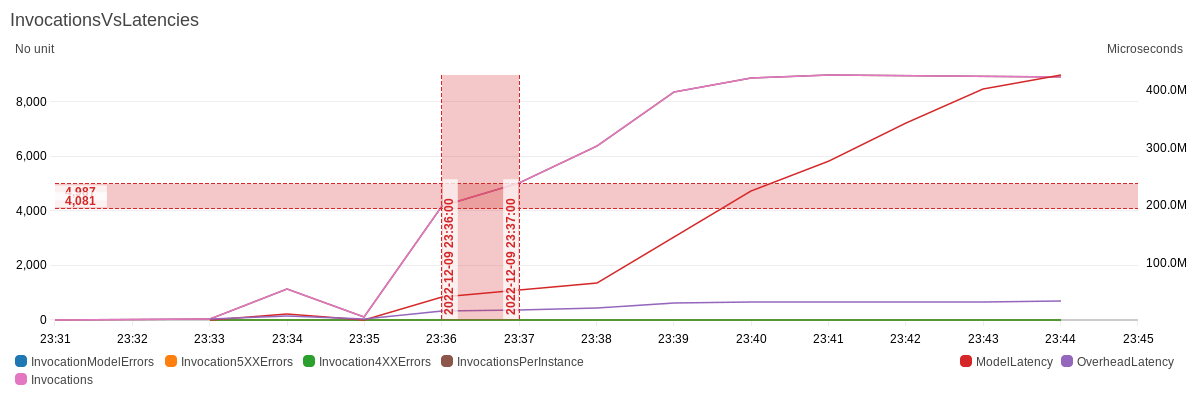

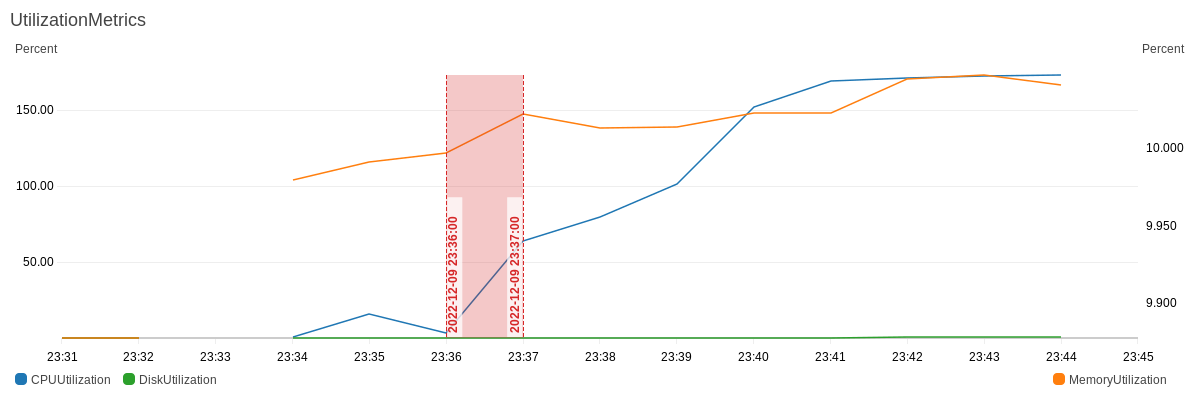

In [8]:
from result_analysis import analysis_inference_recommender_result

# The following function allows you to change the percentage and see how the invocations,
# latency and utilization metrics limit. we highly recommended that you play around with
# different percentage thresholds and find the best fit based on your metrics.
# For this use-case, we have decided to proceed with a threshold between 45 - 55%
max_value, upper_limit, lower_limit = analysis_inference_recommender_result(
    job_name=job_name, index=0, upper_threshold=55.0, lower_threshold=45.0
)

## 7. Set Scaling expectation:

The next step in the plan is to set the scaling expectation and develop scaling policies based on that expectation. This step involves defining the maximum and minimum requests to be served.

For our application, the expectations are maximum requests per second (max) = 500, and minimum request per second (min) = 70. 

In [9]:
import math

# Scaling expectation
max_tps = 500
min_tps = 70

# Based on the above set expectation, we define the MinCapacity and MaxCapacity using the formula below.
# As InvocationsPerInstance is per minute, we normalize it second for the below calculation.
tps_single_instance = upper_limit / 60

# The growth factor is the amount of additional capacity that you are willing to add when your scale exceeds max_tps
growth_factor = 1.2
max_capacity = math.ceil((max_tps / tps_single_instance) * growth_factor)
min_capacity = math.ceil((min_tps / tps_single_instance))
invocations_per_instance = upper_limit
print(
    "Scaling configuration: MaxCapacity = {}, MinCapacity = {}, InvocationsPerInstance = {}".format(
        max_capacity, min_capacity, invocations_per_instance
    )
)

Scaling configuration: MaxCapacity = 8, MinCapacity = 1, InvocationsPerInstance = 4987


## 8. Create endpoint and set scaling policy

The final step in the plan is to define a scaling policy and evaluate its impact. The evaluation step is essential to validate the results of the calculations made so far. In addition, it helps us adjust the scaling setting if it does not meet the need. 

The first step in this procedure is to provision an Endpoint.

In [10]:
from sagemaker.model import Model

# create an evaluation endpoint
endpoint_name = "evaluation-endpoint-" + str(round(time.time()))
model = Model(image_uri=container_url, model_data=model_url, role=role)

predictor = model.deploy(
    initial_instance_count=min_capacity, instance_type=instance_type, endpoint_name=endpoint_name
)

endpoint = sm_client.describe_endpoint(EndpointName=endpoint_name)
variant_name = endpoint["ProductionVariants"][0]["VariantName"]
print("Endpoint details: EndpointName = {}, VariantName = {}".format(endpoint_name, variant_name))

-----!Endpoint details: EndpointName = evaluation-endpoint-1670630230, VariantName = AllTraffic


## 8a. Apply scaling policies to SageMaker endpoint

In order to define the scaling policies, you should register scaling and then add policies. The following section defines functions for registering scaling, setting target tracking policies on CPU utilization and InvocationsPerInstance.

We use the defined functions to apply scaling configuration to provision SageMaker endpoint

In [11]:
from endpoint_scaling import register_scaling
from endpoint_scaling import set_target_scaling_on_invocation
from endpoint_scaling import set_target_scaling_on_cpu_utilization

register_scaling_response = register_scaling(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    max_capacity=max_capacity,
    min_capacity=min_capacity,
)

invocation_scaling = set_target_scaling_on_invocation(
    endpoint_name=endpoint_name, variant_name=variant_name, target_value=invocations_per_instance
)

cpu_scaling = set_target_scaling_on_cpu_utilization(
    endpoint_name=endpoint_name, variant_name=variant_name, target_value=100
)

## 8c. Evaluate the scaling policy

The evaluation is done using the Inference recommender `Advanced` job, where we specify the traffic pattern, MaxInvocations and Endpoint to benchmark against. In this case, we provision the endpoint and set the scaling policies, then run the inference recommender `Advanced` job to validate the policy.

Inference Recommender Job scaling-evaluation-1670630383 is in progress
Inference Recommender Job scaling-evaluation-1670630383 is in progress
Inference Recommender Job scaling-evaluation-1670630383 is in progress
Inference Recommender Job scaling-evaluation-1670630383 is in progress
Inference Recommender Job scaling-evaluation-1670630383 is in progress
Inference recommender job completed
Evaluation job = scaling-evaluation-1670630383, EndpointName = evaluation-endpoint-1670630230


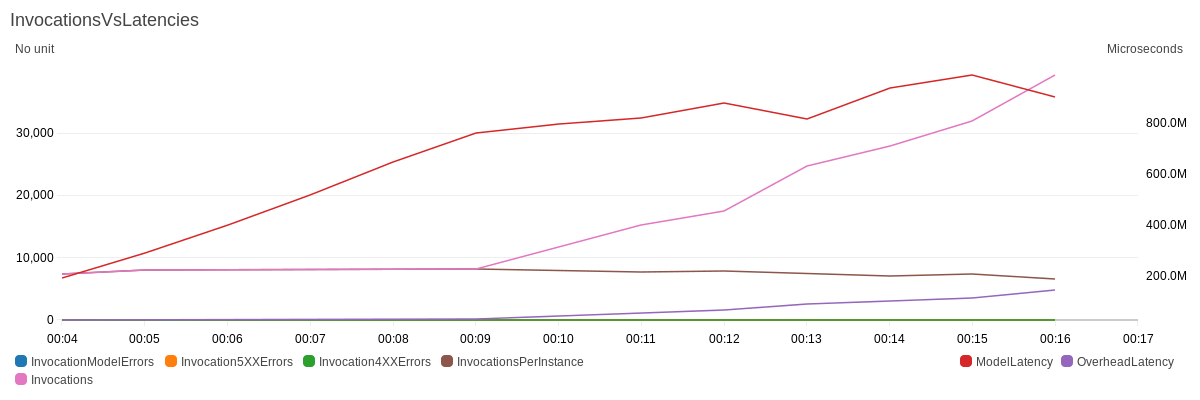

Max invocation realized = 39783.0, and the expecation is 30000


In [12]:
from inference_recommender import trigger_inference_recommender_evaluation_job
from result_analysis import analysis_evaluation_result

eval_job = trigger_inference_recommender_evaluation_job(
    model_package_arn=model_package_arn,
    execution_role=role,
    endpoint_name=endpoint_name,
    instance_type=instance_type,
    max_invocations=max_tps * 60,
    max_model_latency=10000,
    spawn_rate=1,
)

print("Evaluation job = {}, EndpointName = {}".format(eval_job, endpoint_name))

# In the next step, we will visualize the cloudwatch metrics and verify if we reach 30000 invocation.
max_value = analysis_evaluation_result(endpoint_name, variant_name, job_name=eval_job)

print("Max invocation realized = {}, and the expecation is {}".format(max_value, 30000))

Now with the scaling policy, we could achieve 500 TPS at a request rate where we increase one user per minute. But does the same policy work when we increase the request rate twice? Let's rerun the same evaluation set with a higher request rate. 

To execute the step again, clear the auto scaling policies we set before and reset to the initial instance count.

In [27]:
from endpoint_scaling import clear_auto_scaling_and_reset_to_initialCount

# clear scaling and reset to initial count
clear_auto_scaling_and_reset_to_initialCount(
    endpoint_name=endpoint_name, variant_name=variant_name, intial_count=min_capacity
)

Endpoint evaluation-endpoint-1670630230 is in updating/creating
Endpoint evaluation-endpoint-1670630230 is in updating/creating
Endpoint evaluation-endpoint-1670630230 is in InService state


We use the same defined functions to apply scaling configuration to provision SageMaker endpoint, again.

In [28]:
from endpoint_scaling import register_scaling
from endpoint_scaling import set_target_scaling_on_invocation
from endpoint_scaling import set_target_scaling_on_cpu_utilization

register_scaling_response = register_scaling(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    max_capacity=max_capacity,
    min_capacity=min_capacity,
)

invocation_scaling = set_target_scaling_on_invocation(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    target_value=invocations_per_instance * 1.3,
)

cpu_scaling = set_target_scaling_on_cpu_utilization(
    endpoint_name=endpoint_name, variant_name=variant_name, target_value=100
)

## 8d. Repeat the process if the anything changes. 

We then increase the request rate (aka spawn rate) to 4 user per minute, meaning we increase the request rate twice as fast. 

In [ ]:
eval_aggregive_job = trigger_inference_recommender_evaluation_job(
    model_package_arn=model_package_arn,
    execution_role=role,
    endpoint_name=endpoint_name,
    instance_type=instance_type,
    max_invocations=max_tps * 60,
    max_model_latency=10000,
    spawn_rate=4,
)

print("Evaluation job = {}, EndpointName = {}".format(eval_job, endpoint_name))

# In the next step, we will visualize the cloudwatch metrics and verify if we reach 30000 invocation.
max_value = analysis_evaluation_result(endpoint_name, variant_name, job_name=eval_aggregive_job)

print("Max invocation realized = {}, and the expecation is {}".format(max_value, 30000))

Inference Recommender Job scaling-evaluation-1671052958 is in progress
Inference Recommender Job scaling-evaluation-1671052958 is in progress
Inference Recommender Job scaling-evaluation-1671052958 is in progress
Inference Recommender Job scaling-evaluation-1671052958 is in progress
Inference Recommender Job scaling-evaluation-1671052958 is in progress


Note, the evaluation fails as the max invocation reached is less than 30000 invocations / 500 TPS. So to improve availability, we now need to alter our scaling policy. 

Using step scaling configuration, we try to set scaling adjustment to provision *n* of instances when a threshold is met. To try Step scaling, we now reset to the initial instance count and attempt setting the revised scaling policies.

In [23]:
from endpoint_scaling import clear_auto_scaling_and_reset_to_initialCount

clear_auto_scaling_and_reset_to_initialCount(
    endpoint_name=endpoint_name, variant_name=variant_name, intial_count=min_capacity
)

Endpoint evaluation-endpoint-1670630230 is in updating/creating
Endpoint evaluation-endpoint-1670630230 is in updating/creating
Endpoint evaluation-endpoint-1670630230 is in InService state


In [ ]:
aas_client = boto3.client("application-autoscaling", region_name=region)


def set_step_scaling(endpoint_name, variant_name):
    policy_name = "step-scaling-{}".format(str(round(time.time())))
    resource_id = "endpoint/{}/variant/{}".format(endpoint_name, variant_name)
    response = aas_client.put_scaling_policy(
        PolicyName=policy_name,
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        PolicyType="StepScaling",
        StepScalingPolicyConfiguration={
            "AdjustmentType": "ChangeInCapacity",
            "StepAdjustments": [
                {
                    "MetricIntervalLowerBound": 0.0,
                    "MetricIntervalUpperBound": 5.0,
                    "ScalingAdjustment": 1,
                },
                {
                    "MetricIntervalLowerBound": 5.0,
                    "MetricIntervalUpperBound": 80.0,
                    "ScalingAdjustment": 3,
                },
                {"MetricIntervalLowerBound": 80.0, "ScalingAdjustment": 4},
            ],
            "MetricAggregationType": "Average",
        },
    )
    return policy_name, response

In [ ]:
from endpoint_scaling import register_scaling
from endpoint_scaling import set_target_scaling_on_invocation
from endpoint_scaling import set_target_scaling_on_cpu_utilization

register_scaling_response = register_scaling(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    max_capacity=max_capacity,
    min_capacity=min_capacity,
)


cpu_scaling = set_target_scaling_on_cpu_utilization(
    endpoint_name=endpoint_name, variant_name=variant_name, target_value=100
)

set_step_scaling(endpoint_name=endpoint_name, variant_name=variant_name)

Repeat the process of evaluation with Inference recommender advanced job.

In [ ]:
eval_aggregive_job = trigger_inference_recommender_evaluation_job(
    model_package_arn=model_package_arn,
    execution_role=role,
    endpoint_name=endpoint_name,
    instance_type=instance_type,
    max_invocations=max_tps * 60,
    max_model_latency=10000,
    spawn_rate=4,
)

print("Evaluation job = {}, EndpointName = {}".format(eval_job, endpoint_name))

# In the next step, we will visualize the cloudwatch metrics and verify if we reach 30000 invocation.
max_value = analysis_evaluation_result(endpoint_name, variant_name, job_name=eval_aggregive_job)

print("Max invocation realized = {}, and the expecation is {}".format(max_value, 30000))

Step scaling now allows us to reach the expected TPS at twice the rate of the original test. 

Therefore, defining the scaling policies and evaluating the results using the Inference recommender is a necessary part of validation. 

## 9. Clean up the resources

If you don't intend on trying out inference or to do anything else with the endpoint, you should delete it.

In [ ]:
predictor.delete_endpoint()

## 10. Conclusion:

The process of defining the scaling policy for your application can be challenging. You must understand the characteristics of the application, determine your scaling needs, and iterate scaling policies to meet those needs. This blog has reviewed each of these steps carefully and explained the approach you should take at each step. Furthermore, the blog simplified the process with the SageMaker Inference recommender. You can find your application characteristics and evaluate scaling policies by using the Inference recommender benchmarking system. The proposed design pattern can help you create a scalable application that takes into account the availability and cost of your application in hours rather than days.